In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
#### Load in the dataset

clr_data = pd.read_csv("/home/dermot.kelly/Dermot_analysis/Phd/Paper_2/microbiome_ml/data/CLR_counts_only.csv", sep=",", header=0)

clr_data.head()

,X0319.6G20,Absconditabacteriales_.SR1.,Acetitomaculum,Agromyces,Alloprevotella,Allorhizobium.Neorhizobium.Pararhizobium.Rhizobium,Alysiella,Anaerobiospirillum,Anaerofustis,Anaeroplasma,...,X.Eubacterium._ventriosum_group,X.Eubacterium._xylanophilum_group,X.Ruminococcus._gauvreauii_group,X.Ruminococcus._gnavus_group,hoa5.07d05_gut_group,p.251.o5,probable_genus_10,uncultured,vadinBE97,ANI_ID
0,4.420113,4.738563,-6.869682,-6.869682,4.420113,2.340759,2.340759,-6.869682,-6.869682,5.672867,...,3.439304,4.132435,-6.869682,-6.869682,-6.869682,-6.869682,-6.869682,7.942778,4.738563,1092082
1,3.342782,2.244237,2.244237,2.244237,2.937334,-6.966204,-6.966204,-6.966204,-6.966204,4.441372,...,-6.966204,-6.966204,-6.966204,-6.966204,-6.966204,-6.966204,-6.966204,7.610113,3.630456,1090424
2,-7.261651,3.558147,-7.261651,-7.261651,-7.261651,1.948789,1.948789,-7.261651,-7.261651,5.382680,...,3.047335,-7.261651,-7.261651,-7.261651,3.558147,-7.261651,-7.261651,8.378409,4.251284,1090450
3,-6.411524,4.590593,-6.411524,2.798917,-6.411524,-6.411524,-6.411524,-6.411524,-6.411524,6.512391,...,-6.411524,-6.411524,-6.411524,-6.411524,-6.411524,-6.411524,-6.411524,8.648142,2.798917,1098931
4,5.501960,5.427852,-6.347445,4.249214,-6.347445,-6.347445,-6.347445,-6.347445,-6.347445,3.961541,...,-6.347445,3.961541,-6.347445,-6.347445,4.472353,3.556092,-6.347445,8.985388,6.473816,1099728


In [3]:
# 1) Keep IDs for labeling, then get features
sample_ids = clr_data["ANI_ID"].astype(str).values
X = clr_data.drop(columns=["ANI_ID"]).astype(float).to_numpy()

# 2) (optional) remove zero-variance features (can occur after CLR)
var = X.var(axis=0)
X = X[:, var > 0]

# 3) Standardize columns (z-score across samples)
Xz = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

# 4) Compute similarity matrix (n_samples x n_samples)
K = (Xz @ Xz.T) / Xz.shape[1]

# 5) Build labeled DataFrame
K_df = pd.DataFrame(K, index=sample_ids, columns=sample_ids)

# --- sanity checks (optional) ---
print("Symmetric:", np.allclose(K_df.values, K_df.values.T))
eigvals = np.linalg.eigvalsh(K_df.values)
print("Min eigenvalue (numerical):", eigvals.min())  # tiny negative (~1e-12) is OK



Symmetric: True
Min eigenvalue (numerical): -5.120091862197335e-15


In [4]:
diagonal = np.diag(K_df)
print("Diagonal range:", diagonal.min(), "to", diagonal.max())

eigenvalues = np.linalg.eigvalsh(K_df.values)
print("Min eigenvalue:", np.min(eigenvalues))
print("All positive?", np.all(eigenvalues >= 0))

Diagonal range: 0.5073138752161023 to 3.6043205881373153
Min eigenvalue: -5.120091862197335e-15
All positive? False


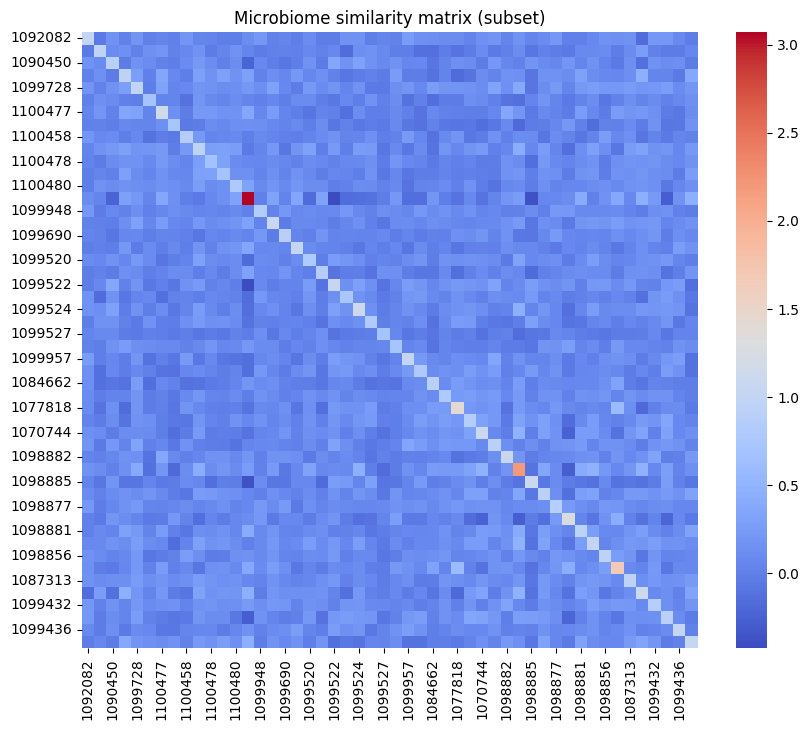

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(K_df.iloc[:50, :50], cmap="coolwarm", square=True)
plt.title("Microbiome similarity matrix (subset)")
plt.show()


In [6]:
# Also save abund_log as will be useful for matrix for LMM

output_path = "/home/dermot.kelly/Dermot_analysis/Phd/Paper_2/microbiome_ml/data/MRM_matrix.csv"

# Save without the index column
K_df.to_csv(output_path, index=True)

print(f"Saved to: {output_path}")

Saved to: /home/dermot.kelly/Dermot_analysis/Phd/Paper_2/microbiome_ml/data/MRM_matrix.csv


In [9]:
# Find the target animal
target_id = "1055179"
target_idx = np.where(sample_ids == target_id)[0][0]
target_vector = Xz[target_idx]

# --- Diagnostics ---
print(f"ID: {target_id}")
print(f"  Mean abundance (after CLR, before z-score): {X.iloc[target_idx].mean():.4f}")
print(f"  Std dev (after CLR, before z-score): {X.iloc[target_idx].std():.4f}")
print(f"  Vector norm after z-score: {np.linalg.norm(target_vector) / np.sqrt(Xz.shape[1]):.4f}")

# Compare to dataset mean & std
mean_std_all = X.std(axis=1).mean()
print(f"  Mean std dev across animals: {mean_std_all:.4f}")

# Which genera are most deviant from mean
diff_from_mean = X.iloc[target_idx] - X.mean(axis=0)
largest_devs = diff_from_mean.abs().sort_values(ascending=False).head(10)
print("\nTop 10 genera by deviation from mean:")
print(largest_devs)

ID: 1055179
  Mean abundance (after CLR, before z-score): -0.0000
  Std dev (after CLR, before z-score): 5.8816
  Vector norm after z-score: 0.7123
  Mean std dev across animals: 5.8531

Top 10 genera by deviation from mean:
Colidextribacter               9.122207
Bacteroidetes_BD2.2            8.242454
WPS.2                          7.605508
Erysipelotrichaceae_UCG.008    7.532624
Mailhella                      7.440579
Intestinimonas                 7.162942
Enterorhabdus                  7.048204
Tyzzerella                     7.002649
Buttiauxella                   6.994401
Oscillibacter                  6.933108
dtype: float64
